In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Modified data loading function for multi-label classification
def load_mnist_data(data_dir):
    splits = ['train', 'val', 'test']
    data = {}
    for split in splits:
        images, labels = [], []
        split_dir = os.path.join(data_dir, split)
        for label in os.listdir(split_dir):
            label_dir = os.path.join(split_dir, label)
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                images.append(img_path)

                digit_one_hots = []
                if label!="0":
                    for digit in label[:3]:  # Limit to first 3 digits if more are present
                        one_hot_label = [0] * 10  # 10 possible digits (0-9)
                        one_hot_label[int(digit)] = 1
                        digit_one_hots.append(one_hot_label)
                
                # If fewer than 3 digits, pad with zero vectors
                while len(digit_one_hots) < 3:
                    digit_one_hots.append([0] * 10)
                # Flatten list of one-hot encodings for compatibility
                labels.append([item for sublist in digit_one_hots for item in sublist])
        data[split] = (images, labels)
    return data['train'], data['val'], data['test']

# Multi-label dataset class
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)  # Convert label to float tensor
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((40, 168)),
    transforms.ToTensor()
])

# Load datasets
train_data, val_data, test_data = load_mnist_data('')
train_dataset = MultiMNISTDataset(*train_data, transform=transform)
val_dataset = MultiMNISTDataset(*val_data, transform=transform)
test_dataset = MultiMNISTDataset(*test_data, transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
import torch.nn as nn

# Define a multi-label CNN class
class MultiLabelCNN(nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 28 x 28
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 14 x 14
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 7 x 7
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256 x 3 x 3
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5120, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 30),  # 10 outputs for multi-label (digits 0-9)
            nn.Sigmoid()  # Use Sigmoid for multi-label classification
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Instantiate the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available(),device)
model = MultiLabelCNN().to(device)

True cuda


In [6]:
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update loss and accuracy
            epoch_loss += loss.item()
        
        # Average metrics for the epoch
        avg_loss = epoch_loss / len(dataloader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Train the model
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, criterion, optimizer)

Epoch [1/10], Loss: 0.2481
Epoch [2/10], Loss: 0.1801
Epoch [3/10], Loss: 0.1290
Epoch [4/10], Loss: 0.0855
Epoch [5/10], Loss: 0.0600
Epoch [6/10], Loss: 0.0454
Epoch [7/10], Loss: 0.0372
Epoch [8/10], Loss: 0.0310
Epoch [9/10], Loss: 0.0261
Epoch [10/10], Loss: 0.0218


In [7]:
torch.save(model.state_dict(), "digit_recognizer.pth")

In [8]:
import torch
import torch.nn as nn

class SumOfDigitsPredictor(nn.Module):
    def __init__(self, trained_model):
        super(SumOfDigitsPredictor, self).__init__()
        # Use the conv_layers from the trained model
        self.conv_layers = trained_model.conv_layers
        
        # New head for sum prediction
        self.sum_head = nn.Sequential(
            nn.Linear(5120, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Single output for sum of digits
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.sum_head(x)
        return x

# Load the trained model
trained_model = model
#  if the trained weights are saved:
# trained_model.load_state_dict(torch.load("digit_recognizer.pth"))

# Create the sum predictor model
sum_predictor = SumOfDigitsPredictor(trained_model).to(device)

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models


train_data1 = np.load('data0.npy')
train_lab1 = np.load('lab0.npy')
train_data2 = np.load('data1.npy')
train_lab2 = np.load('lab1.npy')
train_data3 = np.load('data2.npy')
train_lab3 = np.load('lab2.npy')

#Combine Data
train_data = np.concatenate([train_data1, train_data2, train_data3], axis=0)
train_labels = np.concatenate([train_lab1, train_lab2, train_lab3], axis=0)

#Normalize
train_data = train_data.astype(np.float32) / 255.0
train_labels = train_labels.astype(np.float32)

train_data = torch.tensor(train_data).unsqueeze(1)  
train_labels = torch.tensor(train_labels)

# 80-20 Split into Train and Val
dataset = TensorDataset(train_data, train_labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.MSELoss()  # Mean Squared Error for regression task
optimizer = optim.Adam(sum_predictor.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Adjust based on requirements
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    # Training phase
    sum_predictor.train()  # Set model to training mode
    train_loss = 0.0

    for batch_data, batch_labels in train_loader:
        # Move data to the appropriate device
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # Forward pass
        outputs = sum_predictor(batch_data).squeeze()  # Outputs are (batch_size, 1); squeeze to match labels
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Average loss
    train_loss_history.append(train_loss)

    # Validation phase
    sum_predictor.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # Forward pass
            outputs = sum_predictor(batch_data).squeeze()
            loss = criterion(outputs, batch_labels)

            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average loss
    val_loss_history.append(val_loss)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")

# save the trained model
torch.save(sum_predictor.state_dict(), "sum_predictor_model.pth")

Epoch 1/100:
  Train Loss: 6.0086
  Val Loss: 2.2099
Epoch 2/100:
  Train Loss: 5.6640
  Val Loss: 2.3576
Epoch 3/100:
  Train Loss: 5.5940
  Val Loss: 1.9101
Epoch 4/100:
  Train Loss: 5.3053
  Val Loss: 1.8050
Epoch 5/100:
  Train Loss: 5.3266
  Val Loss: 2.0175
Epoch 6/100:
  Train Loss: 5.0790
  Val Loss: 2.0697
Epoch 7/100:
  Train Loss: 4.9639
  Val Loss: 1.8410
Epoch 8/100:
  Train Loss: 4.8269
  Val Loss: 1.8227
Epoch 9/100:
  Train Loss: 4.7611
  Val Loss: 5.1730
Epoch 10/100:
  Train Loss: 4.6367
  Val Loss: 2.9684
Epoch 11/100:
  Train Loss: 4.5701
  Val Loss: 1.6837
Epoch 12/100:
  Train Loss: 4.3315
  Val Loss: 1.6583
Epoch 13/100:
  Train Loss: 4.2484
  Val Loss: 2.1951
Epoch 14/100:
  Train Loss: 4.1788
  Val Loss: 1.7074
Epoch 15/100:
  Train Loss: 4.0097
  Val Loss: 1.6086
Epoch 16/100:
  Train Loss: 3.8414
  Val Loss: 2.2157
Epoch 17/100:
  Train Loss: 3.8156
  Val Loss: 1.7447
Epoch 18/100:
  Train Loss: 3.9166
  Val Loss: 1.6431
Epoch 19/100:
  Train Loss: 3.7005
  

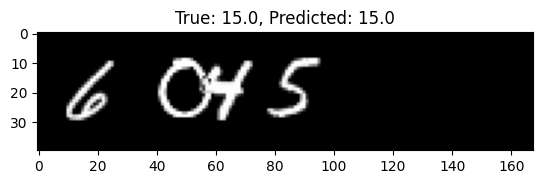

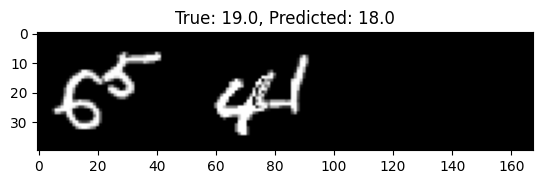

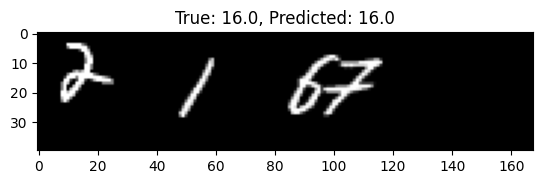

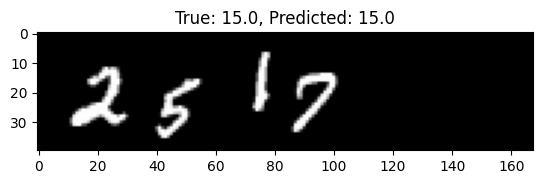

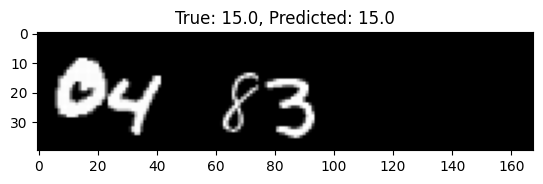

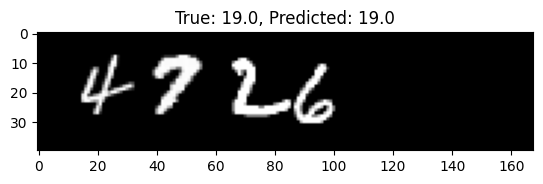

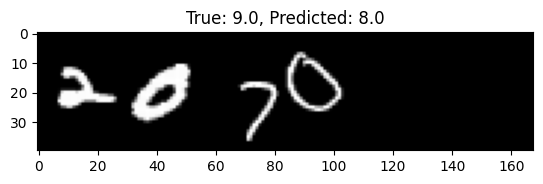

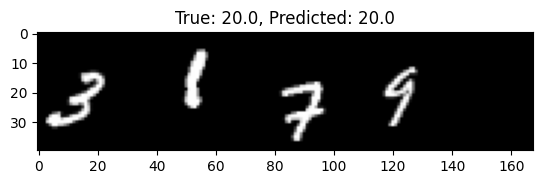

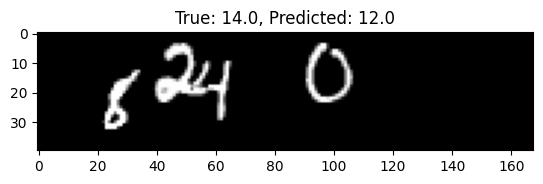

47.13333333333333

In [12]:
from matplotlib import pyplot as plt
correct = 0
total=0
sum_predictor.eval()
sum_predictor.to(device)
i=0
with torch.no_grad():
    for inputs, targets in val_loader:
        i+=1
        inputs, targets = inputs.to(device,torch.float32), targets.to(device,torch.float32)
        outputs = sum_predictor(inputs).squeeze()
        outputs = torch.round(outputs)
        correct += (outputs == targets).sum().item()
        total += targets.size(0)
        if i % 10 == 0: 
            img = inputs[0].cpu().squeeze().numpy()  
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {targets[0].item()}, Predicted: {outputs[0].item()}")
            plt.show()
    correct = 100 * correct/total
correct

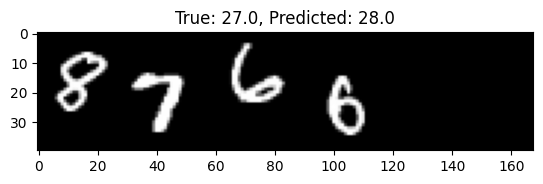

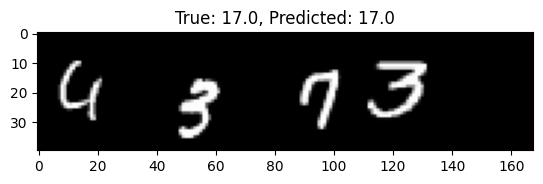

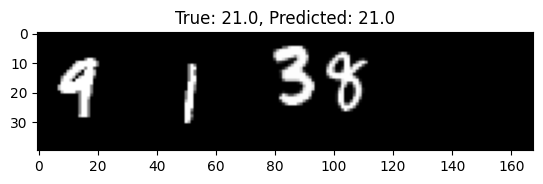

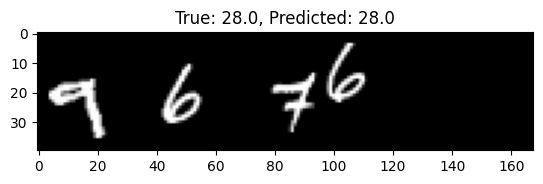

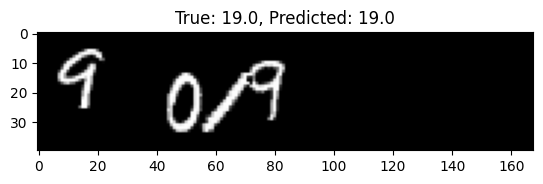

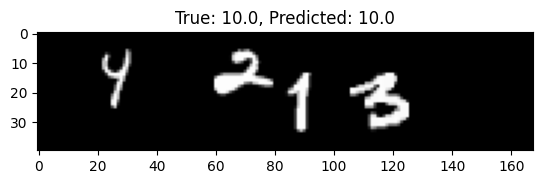

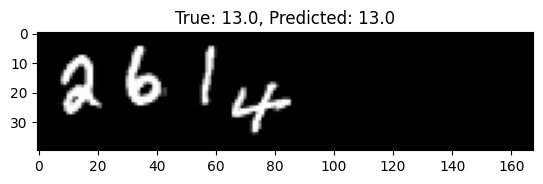

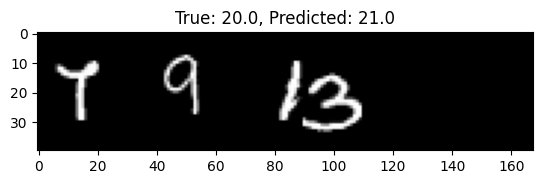

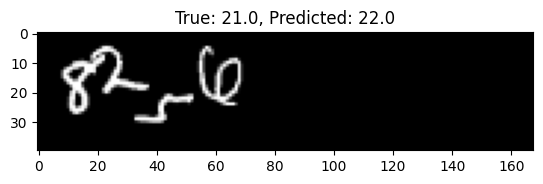

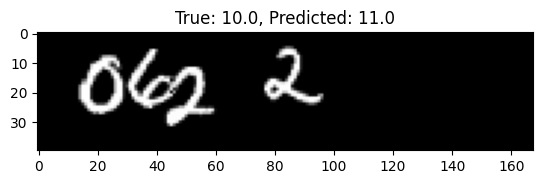

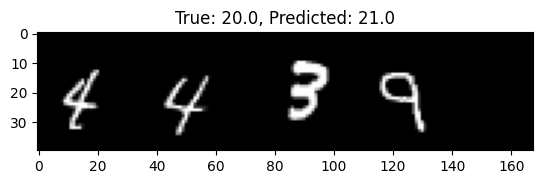

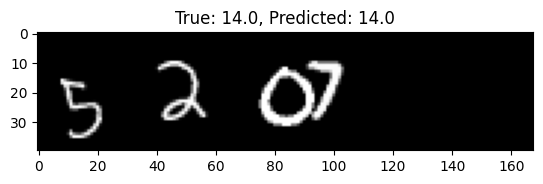

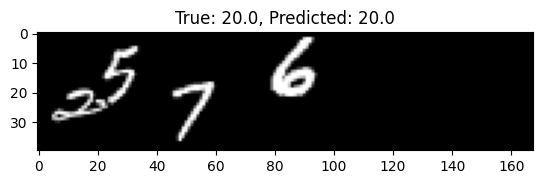

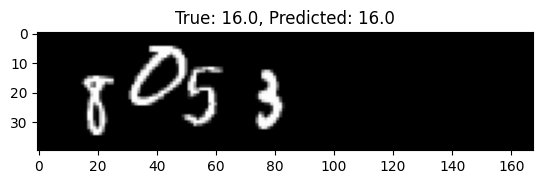

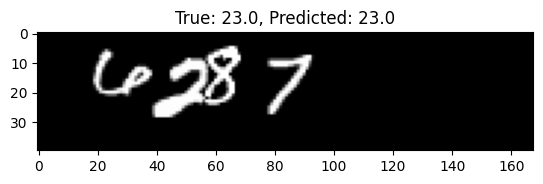

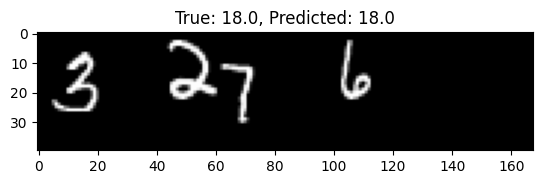

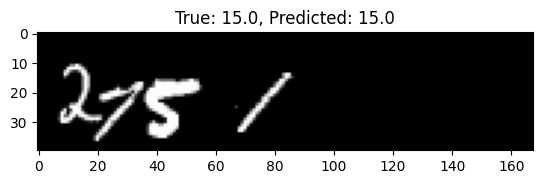

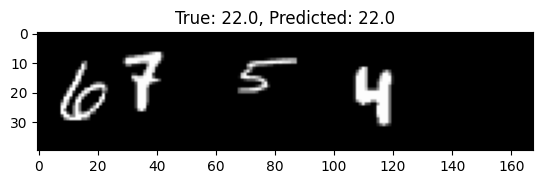

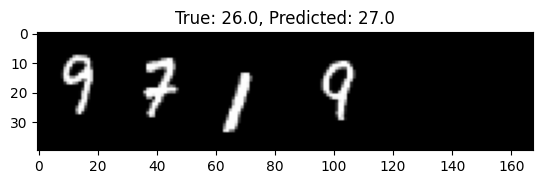

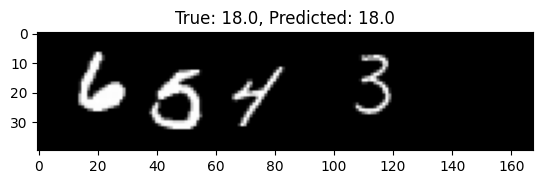

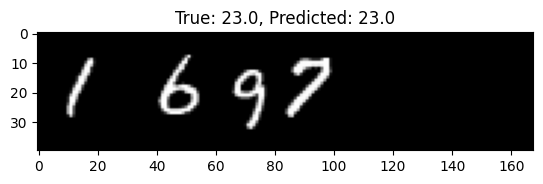

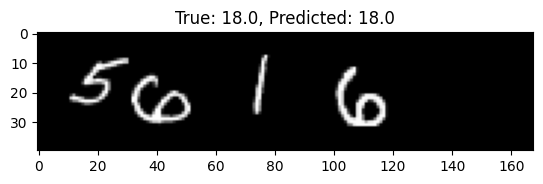

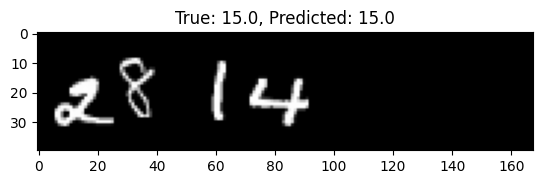

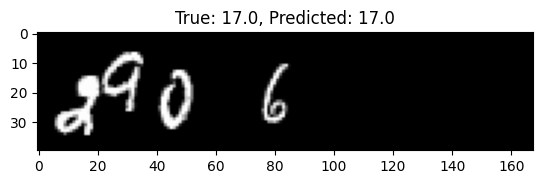

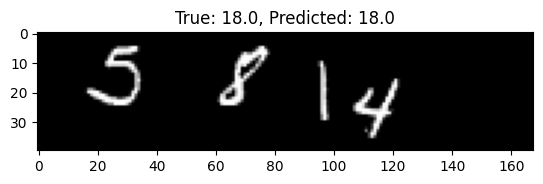

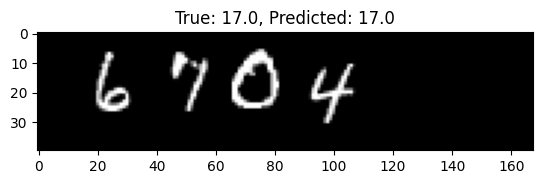

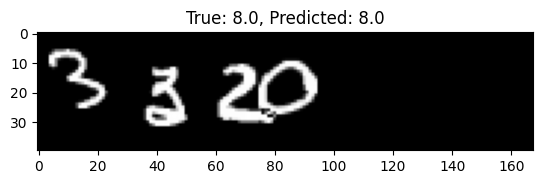

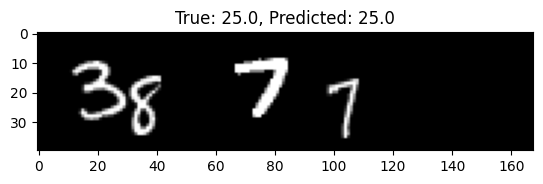

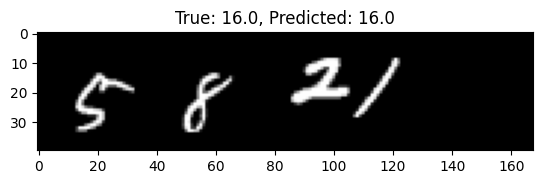

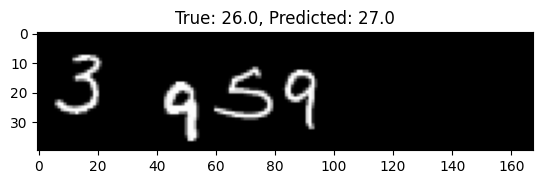

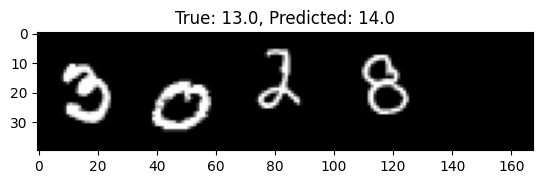

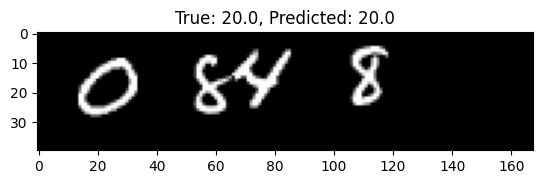

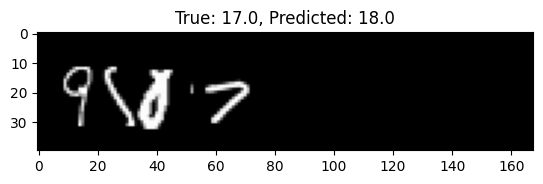

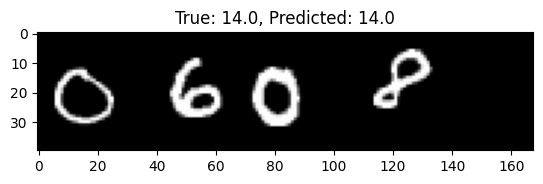

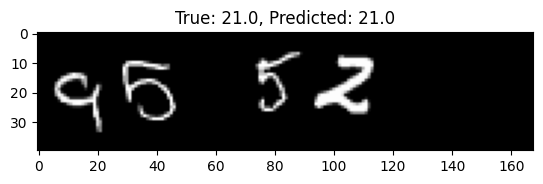

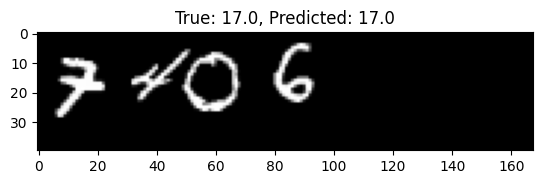

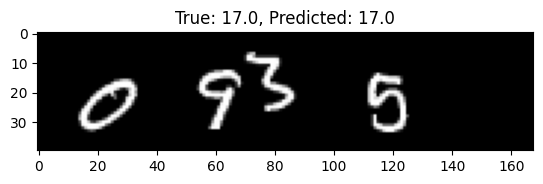

75.45416666666667

In [13]:
from matplotlib import pyplot as plt
correct = 0
total=0
sum_predictor.eval()
sum_predictor.to(device)
i=0
with torch.no_grad():
    for inputs, targets in train_loader:
        i+=1
        inputs, targets = inputs.to(device,torch.float32), targets.to(device,torch.float32)
        outputs = sum_predictor(inputs).squeeze()
        outputs = torch.round(outputs)
        correct += (outputs == targets).sum().item()
        total += targets.size(0)
        if i % 10 == 0: 
            img = inputs[0].cpu().squeeze().numpy()  
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {targets[0].item()}, Predicted: {outputs[0].item()}")
            plt.show()
    correct = 100 * correct/total
correct